### ASI assessed exercise 2016/2017

#### Student: <b>Gaballo</b> Alessandro

## 1. Introduction

In [1]:
# keras and tensorflow are required
from keras.datasets import mnist
from keras.datasets import cifar10
from time import time
from scipy.stats import norm
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


Using TensorFlow backend.


 <b>Q1.</b> Download the MNIST and CIFAR10 datasets and import them.

In [2]:
(mnist_train, mnist_train_label), (mnist_test, mnist_test_label) = mnist.load_data()
(cifar_train, cifar_train_label), (cifar_test, cifar_test_label) = cifar10.load_data()

<b>Q2.</b> Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.

In [3]:
mnist_training_count, bins = np.histogram(mnist_train_label, bins=10)
mnist_test_count, bins = np.histogram(mnist_test_label, bins=10)

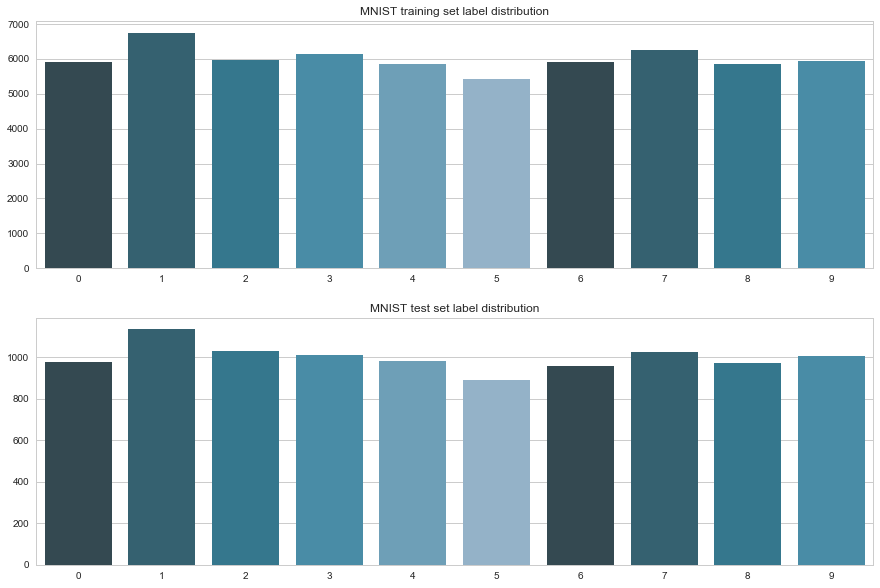

In [4]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.title("MNIST training set label distribution")
sns.barplot(np.arange(10), mnist_training_count, palette=sns.color_palette("PuBuGn_d"))
plt.xticks(np.arange(10))
plt.subplot(212)
plt.title("MNIST test set label distribution")
sns.barplot(np.arange(10), mnist_test_count, palette=sns.color_palette("PuBuGn_d"))
plt.xticks(np.arange(10))
plt.show()

TODO: comment on label distribution

In [5]:
cifar_training_count, bins = np.histogram(cifar_train_label, bins=10)
cifar_test_count, bins = np.histogram(cifar_test_label, bins=10)

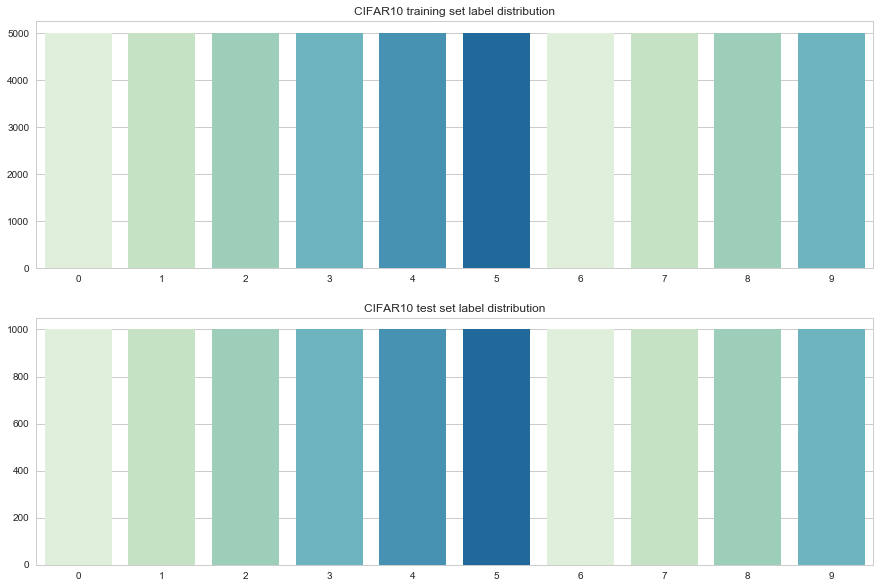

In [6]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.title("CIFAR10 training set label distribution")
sns.barplot(np.arange(10), cifar_training_count, palette=sns.color_palette("GnBu"))
plt.xticks(np.arange(10))
plt.subplot(212)
plt.title("CIFAR10 test set label distribution")
sns.barplot(np.arange(10), cifar_test_count, palette=sns.color_palette("GnBu"))
plt.xticks(np.arange(10))
plt.show()

TODO: comment on label distribution

## 2. Classification

###### Q1. Implement the Naïve Bayes classifier

In [7]:
class NaiveBayesClassifier(object):
    def __init__(self, normalize='continuous'):       
        self.normalize = normalize
        self.prior = []
        self.mean_var = {}
        print("Created new instance of Naive Bayes Classifier")
    
    def _prior(labels):
        num_labels = len(np.unique(labels))
        label, counts = np.unique(labels, return_counts = True)
        priors = np.zeros(num_labels)
        for i in range(num_labels):
            priors[label[i]] = counts[i]
        return priors/len(labels)
    # ---- coin flip ----#
    def _partial(data):
        count = {}
        for digit in data:
            count[digit] = (np.count_nonzero(data[digit], axis=0)+1)/(len(data[digit])+2)
        return count
    
    def _cnt_likelihood(self, sample):
        def _log_like(partial, x):
            return x*np.log(partial) + ((1-x)*np.log(1-partial))
            
            
        sample = sample.flatten()
        likelihoods = np.float128(np.zeros(10))
        for digit in self.partial:
            likelihoods[digit] = np.sum(_log_like(self.partial[digit], sample))
        return likelihoods
    
       
    def _posterior_2(self, likelihoods):
        return np.sum([np.log(self.prior), likelihoods], axis=0)
    # ------------------ #    
    
    def _mean_var(data):
        mean_var = {}
        for digit in data:
            mean = np.mean(data[digit], axis=0)
            var = np.var(data[digit], axis=0) + 1e-3
            # removing 0 value var
            #var_non_0 = np.asarray([v if v != 0 else 1e-3 for v in var])
            mean_var[digit]=(mean, var)
        return mean_var

    def _likelihood(self, sample):
        def _normal(mean, var, x):
            return norm(mean, var).logpdf(x)
            #return np.float128(np.exp(-(x-mean)/(2*var)) / np.sqrt(2*np.pi*var))

        
        sample = sample.flatten()
        likelihoods = np.float128(np.zeros(10))
        for i, (mean, var) in enumerate(self.mean_var.values()):
            likelihoods[i] = np.sum(_normal(mean, var, sample))
        return likelihoods

    def like(mean, var, sample):
        sample = sample.flatten()
        return np.prod(np.float128(np.exp(-(sample-mean)/(2*var)) / np.sqrt(2*np.pi*var)))
    
    def _marginal(self, likelihoods):
        return np.sum(likelihoods * self.prior)
    
    def _posterior(self, likelihoods, marginal):
        return (self.prior*likelihoods)/marginal

    
    def fit(self, data, labels):
        t0 = time()
        data_norm = data
        if self.normalize == 'binary':
            data_norm = np.round(data / 255)
        else:
            data_norm = data / 255

        #computing prior probabilities for different classes
        self.prior = NaiveBayesClassifier._prior(labels)
        
        # now we need to group all the images of each digit
        # digits_imgs contains the list of images(flattened) for each digit 
        digits_imgs = {label:[] for label in np.unique(labels)}
        for img, label in zip(data_norm, labels):
            digits_imgs[label].append(img.flatten())
        # once we've grouped all the samples per digit we can compute the mean and var 
        #self.mean_var = NaiveBayesClassifier._mean_var(digits_imgs)
        self.partial = NaiveBayesClassifier._partial(digits_imgs)
        t1 = time()
        print('Training time {:.3f} s'.format(t1-t0))


    def predict(self, data, probability=False):
        t0 = time()
        data_norm = data
        if self.normalize == 'binary':
            data_norm = np.round(data / 255)
        else:
            data_norm = data / 255
        
        predictions = []
        for sample in data_norm:
            #likelihoods = self._likelihood(sample)
            likelihoods = self._cnt_likelihood(sample)
            #marginal = self._marginal(likelihoods)
            #posterior = self._posterior(likelihoods, marginal)
            posterior = self._posterior_2(likelihoods)
            predictions.append(posterior)

        t1 = time()
        print('Classification time {:.3f} s'.format(t1-t0))

        if probability:
            return predictions
        else:
            pred_labels = [np.argmax(posterior) for posterior in predictions]
        return pred_labels
    
    def pred_proba(self, data):
        return self.predict(data, probability=True)

###### Q2. Describe a positive and a negative feature of the classifier for these tasks

TODO:

###### Q3. Describe any data pre-processing that you suggest for this data and your classifier
TODO:

###### Q4. Apply your classifier to the two given datasets. Make sure your optimization is clearly commented. <br>Use classification accuracy and test log-likelihood as your figures of merit

In [8]:
print("MNIST data shape: {}".format(mnist_test.shape))
print("MNIST labels shape: {}".format(mnist_test_label.shape))
print("CIFAR10 data shape: {}".format(cifar_test.shape))
print("CIFAR10 labels shape: {}".format(cifar_test_label.shape))

MNIST data shape: (10000, 28, 28)
MNIST labels shape: (10000,)
CIFAR10 data shape: (10000, 32, 32, 3)
CIFAR10 labels shape: (10000, 1)


In [9]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

mnist_classifier = NaiveBayesClassifier(normalize='binary')
mnist_classifier.fit(mnist_train, mnist_train_label)

mnist_predicted =  mnist_classifier.predict(mnist_test)
mnist_predicted_prob = mnist_classifier.pred_proba(mnist_test)
print("Classification accuracy {:.2f}%".format(accuracy_score(mnist_test_label, mnist_predicted)*100))
print("Classification log-likelihood {:.2f}%".format(log_loss(mnist_test_label, mnist_predicted_prob)))

Created new instance of Naive Bayes Classifier
Training time 0.886 s
Classification time 16.742 s
Classification time 16.782 s
Classification accuracy 84.27%
Classification log-likelihood 2.30%


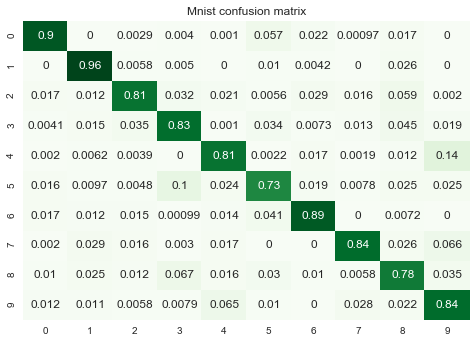

In [10]:
import seaborn as sns

m = confusion_matrix(mnist_test_label, mnist_predicted)
b = m / m.sum(axis=1)
ax = sns.heatmap(b, cbar=False, cmap='Greens', annot=True, yticklabels=np.arange(10))
plt.title("Mnist confusion matrix")
plt.show()

<div class="alert alert-warning">
We implemented the class $NaiveBayesClassifier$ which will work on a flattened version of the images, that means that it doesn't matter if the format of the input is grayscale (<b>mnist</b>) or rgb (<b>cifar</b>) because the corresponding matrix/matrixes will be transformed in a monodimensional array. On the other hand we need to reshape the CIFAR10's labels because they have a different format, the transformation will be:<br> 

Training set: $(50000, 1) \rightarrow (50000,)$<br>
Test set: $(10000, 1) \rightarrow (10000,)$<br>
so that our classifier will work indiscriminately with both of the dataset.
</div>

In [11]:
cifar_train_label = cifar_train_label.reshape((len(cifar_train_label,)))
cifar_test_label = cifar_test_label.reshape((len(cifar_test_label,)))

In [12]:
cifar_classifier = NaiveBayesClassifier(normalize='binary')
cifar_classifier.fit(cifar_train, cifar_train_label)
cifar_predicted = cifar_classifier.predict(cifar_test)
cifar_predicted_prob = cifar_classifier.pred_proba(cifar_test)
print("Classification accuracy {:.2f}%".format(accuracy_score(cifar_test_label, cifar_predicted)*100))
print("Classification log-likelihood {:.2f}%".format(log_loss(cifar_test_label, cifar_predicted_prob)))

Created new instance of Naive Bayes Classifier
Training time 3.326 s
Classification time 17.671 s
Classification time 17.706 s
Classification accuracy 28.03%
Classification log-likelihood 2.30%


###### Q5. Display the confusion matrix on the test data

###### Q6. Discuss the performance, compare them against a classifier that outputs random class labels, and suggest ways in which performance could be improved 

## 3. Linear Regression

###### Q1. Implement Bayesian linear regression

In [89]:
class BayesianLinearRegression(object):
    def __init__(self, normalize=True):
        self._normalize = normalize
        print("Create new instance of Bayesian Linear Regression")

    def _X(data, order):
        
        data = data.reshape(-1, np.prod(data[0].shape))
        X = np.ones(data.shape)
        for i in range(1,order+1):
            X = np.hstack((X, np.power(data, i)))
        return X
        
    def fit(self, data, labels, order=1):
        t0 = time()
        self.order = order
        if self._normalize:
            data = data / 255
            
        X = BayesianLinearRegression._X(data, order)
        X_t = X.T
        shape = X.shape[1]
        #noise = np.random.normal(size=shape)*np.eye(shape)
        noise = np.diag(np.random.uniform(0, 1, shape ))
        self.w_hat = np.linalg.inv(X_t.dot(X) + noise).dot(X_t).dot(labels)
        t1 = time()
        print("Built model in {:.2f} seconds".format(t1-t0))
        return
    
    def predict(self, data):
        t0 = time()
        if self._normalize:
            data = data / 255
            
        X = BayesianLinearRegression._X(data, self.order)
        predictions = np.round(X.dot(self.w_hat))
        predictions = np.array([0 if p < 0 else 9 if p > 9 else p for p in predictions])
        t1 = time()
        print("Classification time {:.2f} seconds".format(t1-t0))
        return predictions

###### Q2. Treat class labels as continuous and apply regression to the training data

In [90]:
blr = BayesianLinearRegression()
blr.fit(mnist_train, mnist_train_label, order=3)
mnist_predicted_blr = blr.predict(mnist_test)
print("Classification accuracy {:.2f}%".format(accuracy_score(mnist_predicted_blr, mnist_test_label)*100))

Create new instance of Bayesian Linear Regression
Built model in 57.81 seconds
Classification time 0.74 seconds


###### Q3. Produce a scatter plot showing the predictions versus the true targets for the test set and compute the mean squared error on the test set

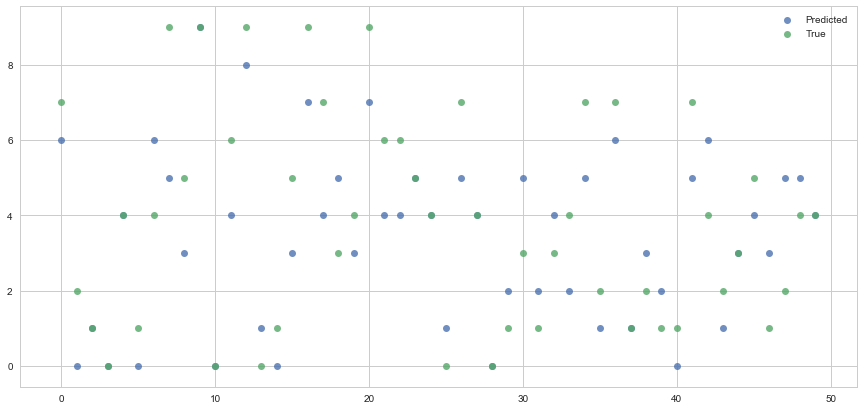

In [108]:
plt.figure(figsize=(15,7))
sns.regplot(np.arange(50), mnist_predicted_blr[:50], fit_reg=False, label='Predicted')
sns.regplot(np.arange(50), mnist_test_label[:50], fit_reg=False, label='True')
plt.legend()
plt.show()

In [111]:
msq = np.mean(np.power(mnist_predicted_blr - mnist_test_label, 2))

2.7075
